# Regional Analyses
Building on the exploratory data analyses, this notebook analyzes and visualizes TML data at the regional level, with a specific focus on results in Central America.

**Agricultural and Urban Areas Meeting Forest Cover Definition (>10%)**  
**Top 5 Admins with Trees on Farms**  
**Top 5 Admins with Urban Trees**  
**Top 5 Admins with Fragmented Forests**
**Tree Cover Distribution: Regional Comparisons** 

In [1]:
import os
import rasterio as rs
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd 
import pandas as pd
import matplotlib
# from bokeh.plotting import figure, save
# from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper

## Create Regional Spreadsheets
Combines country stats spreadsheets into one csv for the region.

In [2]:
def create_regional_csv(list_of_countries, region):
    
    regional_df = pd.DataFrame()
    dfs_to_concat = []
    
    for country in list_of_countries:
        country_df = pd.read_csv(f'/Volumes/Jessicas_Life/_Processed_countries/{country}/stats/{country}_statistics.csv')
        dfs_to_concat.append(country_df)
    
    regional_df = pd.concat(dfs_to_concat, ignore_index=True)
    regional_df.to_csv(f'/Volumes/Jessicas_Life/regional_stats/{region}.csv', index=False)
    
    return None

In [3]:
create_regional_csv(['Belize', 'El Salvador', 'Honduras', 'Nicaragua', 'Panama', 'Guatemala', 'Costa Rica'], 
                    'central_am')

In [18]:
create_regional_csv(['Rwanda', 'Burundi'], 'east_afr')

In [ ]:
create_regional_csv(['Ghana'], 'west_afr')

## Agricultural and Urban Areas Meeting Forest Cover Definition (>10%)
The FAO defines *forest cover* as a land area of more than 0.5 ha, with a tree canopy cover of more than 10%, which is not primarily under agricultural or other specific non-forest land use (FAO 2000). The stacked barchart illustrates the tree cover in agriculture and urban areas that qualifies as forest under this definition. The light green portion indicates the total percentage of land that is not compliant (<10%) and the dark green indicates the total percentage of land that is compliant (>10%) for each country in a region. All results are for the year 2020.

In [15]:
def fao_compliant(region, filepath, lcc):
    
    df = pd.read_csv(filepath)
    
    ag_ids = [10.0, 11.0, 12.0, 20.0, 30.0, 40.0]
    urban_ids = [190.0]
    
    if lcc == 'ag':
        df = df[df.esa_id.isin(ag_ids)]
    
    if lcc == 'urban':
        df = df[df.esa_id.isin(urban_ids)]
        
    # get total ha per threshold per country
    df = df.groupby(by=['country', 'tree_cover_class']).sum().reset_index()
    df = df[['country', 'tree_cover_class', 'tof_ha']] 
    
    # remove tree cover classes <10%
    over10 = df[df.tree_cover_class != '0-9']
    over20 = df[(df.tree_cover_class != '0-9') & (df.tree_cover_class != '10-19')]
    over30 = df[(df.tree_cover_class != '0-9') & (df.tree_cover_class != '10-19') & (df.tree_cover_class != '20-29')]
    
    # calculate totals
    total = sum(df.tof_ha)
    over10_ha = sum(over10.tof_ha)
    over10_perc = sum(over10.tof_ha) / total * 100
    over20_perc = sum(over20.tof_ha) / total * 100
    over30_perc = sum(over30.tof_ha) / total * 100
    
    if lcc == 'ag':
        print(f'Total percentage of ag land in {region} that meets FAO forest cover criterion: {round((over10_perc),2)}%')
        print(f'Total percentage of ag land in {region} with >20% tree cover: {round((over20_perc),2)}%')
        print(f'Total percentage of ag land in {region} with >30% tree cover:  {round((over30_perc),2)}%')
        print(f'Total hectares of ag land in {region} that meet FAO forest cover criterion: {over10_ha} ha')
    
    if lcc == 'urban':
        print(f'Total percentage of urban land in {region} that meets FAO forest cover criterion: {round((over10_perc),2)}%')
        print(f'Total percentage of urban land in {region} with >20% tree cover: {round((over20_perc),2)}%')
        print(f'Total percentage of urban land in {region} with >30% tree cover:  {round((over30_perc),2)}%')
        print(f'Total hectares of urban land in {region} that meet FAO forest cover criterion: {over10_ha} ha')

    return None

In [44]:
fao_compliant('Central America', '/Volumes/Jessicas_Life/regional_stats/central_am.csv', 'ag')

Total percentage of ag land in Central America that meets FAO forest cover criterion: 74.83%
Total percentage of ag land in Central America with >20% tree cover: 62.3%
Total percentage of ag land in Central America with >30% tree cover:  52.35%


In [45]:
fao_compliant('Central America', '/Volumes/Jessicas_Life/regional_stats/central_am.csv', 'urban')

Total percentage of urban land in Central America that meets FAO forest cover criterion: 66.81%
Total percentage of urban land in Central America with >20% tree cover: 45.73%
Total percentage of urban land in Central America with >30% tree cover:  30.81%


In [16]:
fao_compliant('Kenya', 'Kenya_statistics.csv', 'ag')

Total percentage of ag land in Kenya that meets FAO forest cover criterion: 62.96%
Total percentage of ag land in Kenya with >20% tree cover: 47.87%
Total percentage of ag land in Kenya with >30% tree cover:  37.18%
Total hectares of ag land in Kenya that meets FAO forest cover criterion: 17849613 ha


In [17]:
fao_compliant('Kenya', 'Kenya_statistics.csv', 'urban')

Total percentage of urban land in Kenya that meets FAO forest cover criterion: 47.95%
Total percentage of urban land in Kenya with >20% tree cover: 26.75%
Total percentage of urban land in Kenya with >30% tree cover:  15.6%
Total hectares of urban land in Kenya that meets FAO forest cover criterion: 55664 ha


In [37]:
def forest_cover_compliant_comb(region, figsize):
    
    region_df = pd.read_csv(f'/Volumes/Jessicas_Life/regional_stats/{region}.csv')
    
    countries = list(set(region_df.country.values))

    x_labels = []
    bar1 = []
    bar2 = []

    for country in countries:
        
        # filter to one country and only urban/ag land cover classes
        country_df = region_df[region_df.country == country]
        ids = [10.0, 11.0, 12.0, 20.0, 30.0, 40.0, 190.0]
        country_df = country_df[country_df.esa_id.isin(ids)]
        
        # get total tof ha per tree cover threshold
        country_df = country_df.groupby(by=['country', 'tree_cover_class']).sum().reset_index() 
        country_df = country_df[['country', 'tree_cover_class', 'tof_ha']]
        
        # calculate # ha <10% tree cover and >10% tree cover
        under10 = country_df.tof_ha[0]
        over10 = sum(country_df.tof_ha[1:])
        
        # normalize
        total = under10 + over10
        under10_norm = under10/total*100
        over10_norm = over10/total*100
        
        x_labels.append(country)
        bar1.append(over10_norm)
        bar2.append(under10_norm)
   
    # convert to array in order to add data labels
    bar1 = np.asarray(bar1)
    bar2 = np.asarray(bar2)
    
    # create the figure
    plt.figure(figsize=figsize)
    plt.bar(x_labels, bar1, color="seagreen", label='<10% cover')  
    plt.bar(x_labels, bar2, bottom=bar1, color="honeydew", label='>10% cover')    
    
    # labels
    for xpos, ypos, yval in zip(x_labels, bar1/2, bar1):
        plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
    for xpos, ypos, yval in zip(x_labels, bar1 + bar2/2, bar2):
        plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
    
    plt.xlabel(' ')
    plt.ylabel('% Land')
    plt.ticklabel_format(style='plain', axis='y')
    plt.title(f'% Agricultural and Urban Land Meeting \n Forest Cover Definition')
    plt.legend(loc='lower right');

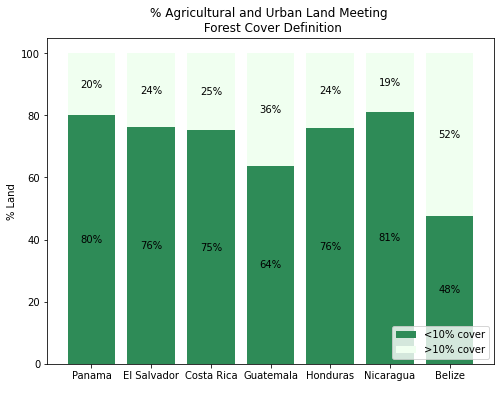

In [38]:
forest_cover_compliant_comb('central_am', (8,6))

In [15]:
def forest_cover_compliant(region, figsize):
    
    '''
    Legend for ESA land cover categories:
        10: 'Cropland, rainfed',
        11: 'Cropland, rainfed',
        12: 'Cropland, rainfed',
        20: 'Cropland, irrigated or post-flooding',
        30: 'Mosaic cropland / natural vegetation',
        40: 'Mosaic natural vegetation / cropland',
        190: 'Urban areas'
    '''
    
    region_df = pd.read_csv(f'/Volumes/Jessicas_Life/regional_stats/{region}.csv')
    
    countries = list(set(region_df.country.values))

    x_labels, ag_bar1, ag_bar2, urban_bar1, urban_bar2 = [],[],[],[],[]
    
    for country in countries:
        
        # filter to one country and only urban/ag land cover classes
        country_df = region_df[region_df.country == country]
        ag_ids = [10.0, 11.0, 12.0, 20.0, 30.0, 40.0]
        urban_ids = [190.0]
        ag_df = country_df[country_df.esa_id.isin(ag_ids)].sort_values('country')
        urban_df = country_df[country_df.esa_id.isin(urban_ids)].sort_values('country')
        
        # get total tof ha per tree cover threshold
        ag_df = ag_df.groupby(by=['country', 'tree_cover_class']).sum().reset_index() 
        ag_df = ag_df[['country', 'tree_cover_class', 'tof_ha']] 
        urban_df = urban_df.groupby(by=['country', 'tree_cover_class']).sum().reset_index() 
        urban_df = urban_df[['country', 'tree_cover_class', 'tof_ha']] 
        
        # calculate # ha <10% tree cover and >10% tree cover
        ag_under10 = ag_df.tof_ha[0]
        ag_over10 = sum(ag_df.tof_ha[1:])
        urban_under10 = urban_df.tof_ha[0]
        urban_over10 = sum(urban_df.tof_ha[1:])
        
        # normalize
        ag_under10_norm = ag_under10/(ag_under10 + ag_over10)*100
        ag_over10_norm = ag_over10/(ag_under10 + ag_over10)*100
        urban_under10_norm = urban_under10/(urban_under10 + urban_over10)*100
        urban_over10_norm = urban_over10/(urban_under10 + urban_over10)*100
        
        x_labels.append(country)
        ag_bar1.append(ag_over10_norm) # >10% is on the bottom
        ag_bar2.append(ag_under10_norm) # <10% is on the top
        urban_bar1.append(urban_over10_norm) 
        urban_bar2.append(urban_under10_norm) 
   
    # convert to array in order to add data labels
    ag_bar1 = np.asarray(ag_bar1)
    ag_bar2 = np.asarray(ag_bar2)
    urban_bar1 = np.asarray(urban_bar1)
    urban_bar2 = np.asarray(urban_bar2)

    plt.figure(figsize=figsize)
    
    # create ag error bars
    ag_error = []
    lower = [-2.41, -3.64, -3.99, -3.17, -3.89, -3.93, -3.74]
    upper = [1.05, 0.41, -0.06, 0.53, 0.27, 0.03, 0.19]
    for x,y in zip(lower, upper):
        ag_error.append(y-x)
    
    # Ag plot
    plt.subplot(1,2,1)
    plt.bar(x_labels, ag_bar1, color="seagreen", label='>10% tree cover', yerr=ag_error, capsize=4)  
    plt.bar(x_labels, ag_bar2, bottom=ag_bar1, color="honeydew", label='<10% tree cover')    
    
    # labels
    for xpos, ypos, yval in zip(x_labels, ag_bar1/2, ag_bar1):
        plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
    for xpos, ypos, yval in zip(x_labels, ag_bar1 + ag_bar2/2, ag_bar2):
        plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
    
    plt.xlabel(' ')
    plt.ylabel('% Land')
    plt.ticklabel_format(style='plain', axis='y')
    plt.title(f'% Agricultural Land Meeting \n 10% Forest Cover Criteria')
    plt.legend(loc='lower right')
    
    # create urban error bars
    urb_error = []
    lower = [-2.90, -1.91, -3.16, -1.90, -1.94, -2.40, -2.06]
    upper = [1.97, 0.64, 0.17, 0.64, 0.95, 0.92, 0.84]
    for x,y in zip(lower, upper):
        urb_error.append(y-x)

    # Urban plot
    plt.subplot(1,2,2)
    plt.bar(x_labels, urban_bar1, color="seagreen", label='>10% tree cover', yerr=urb_error, capsize=4)  
    plt.bar(x_labels, urban_bar2, bottom=urban_bar1, color="honeydew", label='<10% tree cover')    
    
    # labels
    for xpos, ypos, yval in zip(x_labels, urban_bar1/2, urban_bar1):
        plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
    for xpos, ypos, yval in zip(x_labels, urban_bar1 + urban_bar2/2, urban_bar2):
        plt.text(xpos, ypos, f'{round(yval)}%', ha="center", va="center")
    
    
    plt.xlabel(' ')
    plt.ylabel('% Land')
    plt.ticklabel_format(style='plain', axis='y')
    plt.title(f'% Urban Land Meeting \n 10% Forest Cover Criteria')
    plt.legend(loc='lower right')
    plt.tight_layout(); 

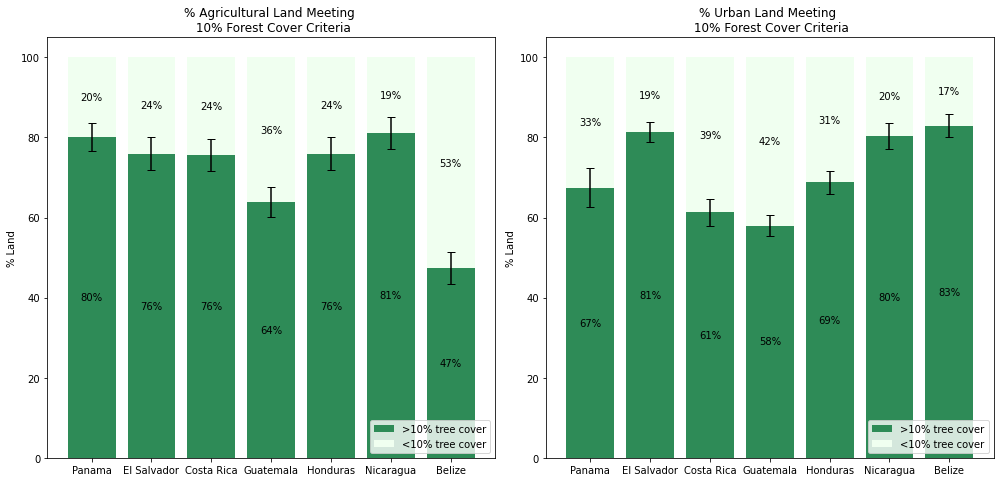

In [16]:
forest_cover_compliant('central_am', (14,7))

## Top 5 Admins with Trees on Farms
This function identifies the top five administrative districts with the highest tree cover estimates (average tree cover or total ha) on agriculture land cover types.  

Outstanding items to address:
- If ha of tree cover is the metric, should be weighted

In [6]:
def top5_admins_ag(filepath):
    
    '''
    Filters dataframe to the following ESA agriculture land cover types:
    
    Cropland, rainfed
    Cropland, rainfed, herbaceous cover
    Cropland, irrigated or post-flooding
    Mosaic cropland / natural vegetation
    Mosaic natural vegetation / cropland 
    
    Calculates the total ha tree cover per admin AND the avg % tree cover per admin.
    Merges the dataframes to include % of land cover class sampled and then builds
    two separate dataframes of top 5 cities in the region with highest stats.
    
    '''
    
    df = pd.read_csv(filepath)
    
    # filter to only ag land cover classes
    ag_ids = [10.0, 11.0, 12.0, 20.0, 30.0, 40.0]
    df = df[df.esa_id.isin(ag_ids)]

    # get total (sum) ha tree cover in ag for each admin (drop ha <10% cover)
    df_ha = df.drop(df[df.tree_cover_class == '0-9'].index)
    df_ha = df.groupby(by=['country', 'admin']).sum().reset_index() 
    df_ha = df_ha[['country', 'admin', 'esa_sampled_ha', 'esa_total_ha','tof_ha']] 
    
    # add column with % of land cover class that was sampled
    df_ha['esa_perc_samp'] = round((df_ha.esa_sampled_ha / df_ha.esa_total_ha) * 100, 2)

    # now use original dataframe to get average tree cover in ag for each admin
    df_avg = df.groupby(by=['country','admin']).mean().reset_index()
    df_avg = df_avg[['country', 'admin', 'tof_mean']]
    
    # merge dataframes
    df_merged = pd.merge(df_ha, df_avg, how='inner', left_on=['country','admin'], right_on=['country','admin'])
    
    # sort and print top 5 ag areas
    top_5_ha = df_merged.sort_values(['tof_ha', 'esa_perc_samp'], ascending=(False, False))[:5]
    top_5_avg = df_merged.sort_values(['tof_mean', 'esa_perc_samp'], ascending=(False, False))[:5]
    
    print('Top 5 Admins with Trees on Farms (total hectares tree cover)')
    for i in top_5_ha.index:
        print(f'Farms in {top_5_ha.admin[i]}, {top_5_ha.country[i]} have {top_5_ha.tof_ha[i]} ' \
              f'ha of tree cover >10%. ({top_5_ha.esa_perc_samp[i]}% of farms were sampled)')
    
    print(' ')
    print('Top 5 Admins with Trees on Farms (average % tree cover)')
    for i in top_5_avg.index:
        print(f'Farms in {top_5_avg.admin[i]}, {top_5_avg.country[i]} have {round(top_5_avg.tof_mean[i], 0)}% ' \
              f'average tree cover. ({top_5_avg.esa_perc_samp[i]}% of farms were sampled)')

    return df_merged

In [4]:
central_am = top5_admins_ag('/Volumes/Jessicas_Life/regional_stats/central_am.csv')

Top 5 Admins with Trees on Farms (total hectares tree cover)
Farms in Petén, Guatemala have 1844046 ha of tree cover >10%. (95.7% of farms were sampled)
Farms in Atlántico Sur, Nicaragua have 1099550 ha of tree cover >10%. (87.86% of farms were sampled)
Farms in Olancho, Honduras have 743352 ha of tree cover >10%. (90.25% of farms were sampled)
Farms in Veraguas, Panama have 568600 ha of tree cover >10%. (96.59% of farms were sampled)
Farms in Chontales, Nicaragua have 544590 ha of tree cover >10%. (95.29% of farms were sampled)
 
Top 5 Admins with Trees on Farms (average % tree cover)
Farms in Emberá, Panama have 66.0% average tree cover. (3.08% of farms were sampled)
Farms in El Progreso, Guatemala have 50.0% average tree cover. (93.43% of farms were sampled)
Farms in Estelí, Nicaragua have 47.0% average tree cover. (66.68% of farms were sampled)
Farms in Sacatepéquez, Guatemala have 47.0% average tree cover. (97.04% of farms were sampled)
Farms in Carazo, Nicaragua have 46.0% averag

In [7]:
top5_admins_ag('Kenya_statistics.csv')

Top 5 Admins with Trees on Farms (total hectares tree cover)
Farms in Kitui, Kenya have 2792608 ha of tree cover >10%. (93.32% of farms were sampled)
Farms in Tana River, Kenya have 1720047 ha of tree cover >10%. (74.13% of farms were sampled)
Farms in Narok, Kenya have 1505035 ha of tree cover >10%. (71.54% of farms were sampled)
Farms in Kajiado, Kenya have 1468629 ha of tree cover >10%. (89.73% of farms were sampled)
Farms in Baringo, Kenya have 1371810 ha of tree cover >10%. (96.39% of farms were sampled)
 
Top 5 Admins with Trees on Farms (average % tree cover)
Farms in Lamu, Kenya have 49.0% average tree cover. (21.65% of farms were sampled)
Farms in Nyeri, Kenya have 46.0% average tree cover. (95.01% of farms were sampled)
Farms in Baringo, Kenya have 44.0% average tree cover. (96.39% of farms were sampled)
Farms in Embu, Kenya have 40.0% average tree cover. (98.81% of farms were sampled)
Farms in Tharaka-Nithi, Kenya have 40.0% average tree cover. (99.11% of farms were sampled)

,country,admin,esa_sampled_ha,esa_total_ha,tof_ha,esa_perc_samp,tof_mean
0,Kenya,Baringo,11635954.1,12071469.4,1371810,96.39,43.605076
1,Kenya,Bomet,2558878.7,3686123.2,285206,69.42,37.203378
2,Kenya,Bungoma,5445037.2,5686541.8,617431,95.75,21.820357
3,Kenya,Busia,3042936.7,4822494.0,320146,63.10,14.712896
4,Kenya,Elgeyo-Marakwet,6004095.1,6038520.4,728884,99.43,26.570254
5,Kenya,Embu,4614148.9,4669943.8,513837,98.81,40.231168
6,Kenya,Garissa,8674104.3,12948649.8,1068571,66.99,26.164810
7,Kenya,Homa Bay,1611634.6,4093830.6,187010,39.37,19.284518
8,Kenya,Isiolo,3948024.1,4076263.2,472368,96.85,32.969250
9,Kenya,Kajiado,12695092.8,14147968.6,1468629,89.73,30.525773


## Top 5 Admins with Urban Trees
This function identifies the top five administrative districts with the highest tree cover estimates (average tree cover or total ha) on urban land cover types.  

Outstanding items to address:
- If ha of tree cover is the metric, should be weighted

In [52]:
def top5_admins_urb(region):
    
    '''
    Filters dataframe to the ESA urban land cover class. 
    
    Calculates the total ha tree cover per admin or the comb avg  % tree cover per admin,
    then sorts values in descending order to get top 5 admins.
    
    '''
    
    df = pd.read_csv(f'/Volumes/Jessicas_Life/regional_stats/{region}.csv')
    
    # filter to only urban land cover class
    df = df[df.esa_id == 190.0]
    
    # get total (sum) ha tree cover in urban class for each admin
    df_ha = df.groupby(by=['country', 'admin']).sum().reset_index() 
    df_ha = df_ha[['country', 'admin', 'esa_sampled_ha', 'esa_total_ha','tof_ha']] 
    
    # add column with % of land cover class that was sampled
    df_ha['esa_perc_samp'] = round((df_ha.esa_sampled_ha / df_ha.esa_total_ha) * 100, 2)

    # now use original dataframe to get average tree cover in urban class for each admin
    df_avg = df.groupby(by=['country','admin']).mean().reset_index()
    df_avg = df_avg[['country', 'admin', 'tof_mean']]
    
    # merge dataframes
    df_merged = pd.merge(df_ha, df_avg, how='inner', left_on=['country','admin'], right_on=['country','admin'])
    
    # sort and print top 5 urban areas
    top_5_ha = df_merged.sort_values(['tof_ha', 'esa_perc_samp'], ascending=(False, False))[:5]
    top_5_ha = top_5_ha.reset_index().drop('index', 1)
    top_5_avg = df_merged.sort_values(['tof_mean', 'esa_perc_samp'], ascending=(False, False))[:5]
    top_5_avg = top_5_avg.reset_index().drop('index', 1)

    
    print('Top 5 Cities with Trees (total hectares tree cover)')
    for i in top_5_ha.index:
        print(f'{top_5_ha.esa_perc_samp[i]}% of urban areas were sampled in {top_5_ha.admin[i]}, ' \
              f'{top_5_ha.country[i]} with {top_5_ha.tof_ha[i]} ha of tree cover >0%.')
    
    print(' ')
    print('Top 5 Cities with Trees (average % tree cover)')
    for i in top_5_avg.index:
        print(f'{top_5_avg.esa_perc_samp[i]}% of urban areas were sampled in {top_5_avg.admin[i]}, ' \
              f'{top_5_avg.country[i]} with {round(top_5_avg.tof_mean[i], 0)}% average tree cover.')
        
    # display top 5 ha
#     num1 = rs.open(f'{top_5_ha.country[0]}/resampled_rasters/tof/{top_5_ha.admin[0]}.tif').read(1)
#     num2 = rs.open(f'{top_5_ha.country[1]}/resampled_rasters/tof/{top_5_ha.admin[1]}.tif').read(1)
    
#     plt.figure(figsize=(30,20))

#     plt.subplot(1,2,1)
#     plt.imshow(num1, cmap='Greens', vmin=0, vmax=100)
#     plt.title(f'#1: {top_5_ha.admin[0]}, {top_5_ha.country[0]} (ha tree cover)')

#     plt.subplot(1,2,2)
#     plt.imshow(num2, cmap='Greens', vmin=0, vmax=100)
#     plt.title(f'#2: {top_5_ha.admin[1]}, {top_5_ha.country[1]} (ha tree cover)')

    # figure out where in that admin has the highest tree cover by lat/lon coordinates?
    # long term could scale down to admin 2 level in these areas?

    return None

In [53]:
top5_admins_urb('central_am')

Top 5 Cities with Trees (total hectares tree cover)
99.12% of urban areas were sampled in Guatemala, Guatemala with 30643 ha of tree cover >0%.
97.48% of urban areas were sampled in San José, Costa Rica with 19143 ha of tree cover >0%.
98.99% of urban areas were sampled in Panamá, Panama with 17230 ha of tree cover >0%.
98.71% of urban areas were sampled in Quezaltenango, Guatemala with 16213 ha of tree cover >0%.
99.02% of urban areas were sampled in San Salvador, El Salvador with 14089 ha of tree cover >0%.
 
Top 5 Cities with Trees (average % tree cover)
0.05% of urban areas were sampled in Gracias a Dios, Honduras with 36.0% average tree cover.
94.04% of urban areas were sampled in Usulután, El Salvador with 36.0% average tree cover.
68.99% of urban areas were sampled in Morazán, El Salvador with 35.0% average tree cover.
100.0% of urban areas were sampled in Madriz, Nicaragua with 33.0% average tree cover.
96.81% of urban areas were sampled in La Libertad, El Salvador with 32.0% a

/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/Users/jessicaertel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [2]:
# new version for multi scale output

def urban_cover_admin(filepath):
    
    '''
    Filters dataframe to the following ESA urban land cover types:
    
    Urban
    
    Calculates the total ha tree cover per admin AND the avg % tree cover per admin.
    Merges the dataframes to include % of land cover class sampled and then builds
    two separate dataframes of top 5 cities in the region with highest stats.
    
    '''
    
    df = pd.read_csv(filepath)
    
    # filter to only urban land cover
    df = df[df.esa_id == 190]

    # get total (sum) ha tree cover in ag for each admin (drop ha <10% cover)
    df_ha = df.drop(df[df.tree_cover_class == '0-9'].index)
    df_ha = df.groupby(by=['country', 'admin']).sum().reset_index() 
    df_ha = df_ha[['country', 'admin', 'esa_sampled_ha', 'esa_total_ha','tof_ha']] 
    
    # add column with % of land cover class that was sampled
    df_ha['esa_perc_samp'] = round((df_ha.esa_sampled_ha / df_ha.esa_total_ha) * 100, 2)

    # now use original dataframe to get average tree cover in ag for each admin
    df_avg = df.groupby(by=['country','admin']).mean().reset_index()
    df_avg = df_avg[['country', 'admin', 'tof_mean']]
    
    # merge dataframes
    df_merged = pd.merge(df_ha, df_avg, how='inner', left_on=['country','admin'], right_on=['country','admin'])
    
    # sort and print top 5 ag areas
    top_5_ha = df_merged.sort_values(['tof_ha', 'esa_perc_samp'], ascending=(False, False))[:5]
    top_5_avg = df_merged.sort_values(['tof_mean', 'esa_perc_samp'], ascending=(False, False))[:5]
    
    print('Top 5 Admins with Urban Tree Cover (total hectares tree cover)')
    for i in top_5_ha.index:
        print(f'Urban areas in {top_5_ha.admin[i]}, {top_5_ha.country[i]} have {top_5_ha.tof_ha[i]} ' \
              f'ha of tree cover >10%. ({top_5_ha.esa_perc_samp[i]}% of urban areas were sampled)')
    
    print(' ')
    print('Top 5 Admins with Urban Tree Cover (average % tree cover)')
    for i in top_5_avg.index:
        print(f'Urban Areas in {top_5_avg.admin[i]}, {top_5_avg.country[i]} have {round(top_5_avg.tof_mean[i], 0)}% ' \
              f'average tree cover. ({top_5_avg.esa_perc_samp[i]}% of urban areas were sampled)')
    
    return df_merged

In [84]:
urban_cover_admin('El Salvador_statistics.csv')

Top 5 Admins with Urban Tree Cover (total hectares tree cover)
Urban areas in San Salvador, El Salvador have 14089 ha of tree cover >10%. (99.02% of urban areas were sampled)
Urban areas in La Libertad, El Salvador have 6340 ha of tree cover >10%. (96.81% of urban areas were sampled)
Urban areas in Santa Ana, El Salvador have 3268 ha of tree cover >10%. (86.91% of urban areas were sampled)
Urban areas in San Miguel, El Salvador have 2346 ha of tree cover >10%. (96.11% of urban areas were sampled)
Urban areas in Sonsonate, El Salvador have 2124 ha of tree cover >10%. (85.98% of urban areas were sampled)
 
Top 5 Admins with Urban Tree Cover (average % tree cover)
Urban Areas in Usulután, El Salvador have 36.0% average tree cover. (94.04% of urban areas were sampled)
Urban Areas in Morazán, El Salvador have 35.0% average tree cover. (68.99% of urban areas were sampled)
Urban Areas in La Libertad, El Salvador have 32.0% average tree cover. (96.81% of urban areas were sampled)
Urban Areas i

,country,admin,esa_sampled_ha,esa_total_ha,tof_ha,esa_perc_samp,tof_mean
0,El Salvador,Ahuachapán,9557.9,10506.4,1194,90.97,30.521196
1,El Salvador,Cabañas,2919.1,5094.1,348,57.30,29.590611
2,El Salvador,Chalatenango,2904.0,4716.0,415,61.58,26.930441
3,El Salvador,Cuscatlán,2211.3,4392.3,296,50.34,27.685457
4,El Salvador,La Libertad,53592.7,55358.3,6340,96.81,32.436768
5,El Salvador,La Paz,8231.5,8418.6,1125,97.78,29.429722
6,El Salvador,La Unión,4683.2,5838.2,620,80.22,30.565937
7,El Salvador,Morazán,1809.0,2622.0,225,68.99,34.565781
8,El Salvador,San Miguel,20778.2,21619.1,2346,96.11,29.322313
9,El Salvador,San Salvador,128694.4,129974.6,14089,99.02,30.721310


## Top 5 Admins with Fragmented Forests
Clarification: are we calculating the number of admins with the "most" fragmented forests and what does that mean?
- fragmented forest: the area of forest within one pixel of the edge
- forest connectivity: the area of disconnected forest fragments

Could replicate the approach used by [Cunningham et al. 2020](https://www.mdpi.com/2072-4292/12/19/3226/htm) and use the Guidos Toolbox [MSPA (Morphological Spatial Pattern Analysis)](https://forest.jrc.ec.europa.eu/en/activities/lpa/mspa/)
- Soille P, Vogt P, 2009. Morphological segmentation of binary patterns. Pattern Recognition Letters 30, 4:456-459, DOI: 10.1016/j.patrec.2008.10.015 

OpenForis example implementation - python?: https://github.com/openforis/mspa-analysis/blob/master/scripts/mspa.py

## Tree Cover Distribution: Regional Comparisons
This grouped barchart compares tree cover distribution in 10% canopy cover thresholds across four regions: Central America, East Africa, West Africa, Sahel). (In the future could consider a facet grid that illustrates the distribution in a barchart per country)

In [19]:
def tree_cover_distribution(central_am, east_afr):
    
    # later will be updated to compare across 4 regions
    #central_am = pd.read_csv('regional_stats/central_am.csv')
    #east_afr = pd.read_csv('regional_stats/east_afr.csv')
    #west_afr = pd.read_csv('regional_stats/west_afr.csv')
    #sahel = pd.read_csv('regional_stats/sahel.csv')

    central_am = central_am.groupby(by=['tree_cover_class']).sum().reset_index() 
    central_am = central_am[['tree_cover_class', 'tof_ha']]

    east_afr = east_afr.groupby(by=['tree_cover_class']).sum().reset_index() 
    east_afr = east_afr[['tree_cover_class', 'tof_ha']]

    labels = list(central_am.tree_cover_class)
    x = np.arange(len(labels))  # the label locations
    width = 0.35  

    plt.figure(figsize=(10,8))
    plt.bar(x - width/2, central_am.tof_ha, width, label='Central America')
    plt.bar(x + width/2, east_afr.tof_ha, width, label='East Africa')

    plt.title('Tree Cover Distribution by Region')
    plt.xlabel('Thresholds (%)')
    plt.ylabel('Total Ha')
    plt.xticks(x, labels=labels)
    plt.ticklabel_format(style='plain', axis='y')
    plt.grid(axis='y', linestyle='-', linewidth=.2)
    plt.legend();
    
    return None

In [20]:
central_am = pd.read_csv('regional_stats/central_am.csv')
east_afr = pd.read_csv('regional_stats/east_afr.csv')

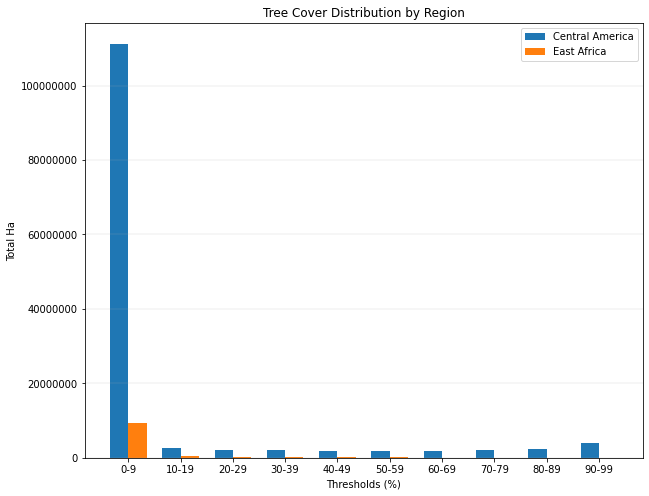

In [21]:
tree_cover_distribution(central_am, east_afr)